# Prevendo futuro de preços usando facebook Prophet

Saber o "futuro" é algo que eu acredito que todas as organizações buscam, desde a quantidade de vendas realizadas na próxima estação, a quantidade de não-conformidades detectadas em um produto, a previsão de demandas em vários setores.

Conhecido como `Time Series` ou Séries Temporais em *estatística*, é uma coleção de observações feitas sequencialmente ao longo do tempo. Um ponto importante que deve ser considerado é que a **ordem dos eventos** é fundamental e uma característica deste tipo de dados é que as **observações vizinhas são dependentes** e o interesse é analisar e modelar essa dependência.

<img src="images/Banner_Facebook_Prophet.png" />

`Facebook Prophet` é uma ferramenta *Open Source* criado pelo *Facebook* em 2017, com o objetivo de `forecasting` ou *previsão* em séries temporais, tanto para uso em Python quanto em R.

As caracaterísticas do Prophet são:
- Observações horárias, diárias ou semanais com pelo menos alguns meses (preferencialmente um ano) de histórico.
- Fortes sazonalidades múltiplas em "escala humana": dia da semana e períodos do ano.
- Feriados importantes que ocorrem em intervalos regulares, conhecidos antecipadamente.
- Um número razoável de observações faltantes ou *outliers*.
- Mudanças de tendências históricas, como lançamento de um produto ou mudança dos registros.
- Curva de tendência com crescimento não-linear, onde a tendência atinge um limite natural.

Com o `Prophet` você não precisa ficar preso aos resultados de um procedimento automático, caso a previsão não for satisfatória, pois mesmo não sendo experiente em métodos de Séries Temporais, é possível ajustar as previsões para melhorias nesse processo usando uma variedade de parâmetros de fácil interpretação.

Vamos demonstrar um exemplo de como funciona esse *framework*.

## Objetivo deste Notebook

**Principal:** Demonstrar o uso, de uma forma simples, da biblioteca `Prophet`.

Etapas do processo:
- Conhecendo o conjunto de dados;
- Análise Exploratória;
- Demonstração das funcionalidades básicas do Prophet;
- Treinamento e teste de um modelo;
- Avaliação do modelo com a métrica MAPE.

## Conhecendo o Conjunto de dados

Vamos usar um conjunto de dados do Kaggle, denominado como <a href="https://www.kaggle.com/neuromusic/avocado-prices">Avocado Prices</a>, que nos dá o histórico de vendas de abacates de 2015 à 2018, somente aos domingos, dos Estados Unidos para demonstrarmos como funciona o Prophet.

Antes de iniciar, vamos dar uma olhada no significado de cada coluna do conjunto de dados.

### Dicionário de dados

- Date: a data da observação
- AveragePrice: o preço médio unitário
- type: convencional ou orgânico
- year: o ano
- Region: a cidade ou região da observação
- Total Volume: número total vendido
- 4046: total vendido com PLU 4046
- 4225: total vendido com PLU 4225
- 4770: total vendido com PLU 4770


*Observações:* 
1. As datas são somente dias de domingo.
2. PLU ou "Price Look up" é utilizado pelos supermercados para identificar os produtos a granel afim de agilizar o check-out e inventário.

### Qual será nossa "variável target"?

Usaremos as variável `AveragePrice` ou `Preços médios` para previsão.

## Importando as bibliotecas e o dataset

As bibliotecas a serem usadas são:
- `Pandas` e `Numpy` para manipulação dos dados e estatísticas.
- `Matplotlib` e `Seaborn` para visualizações.
- `Prophet` para séries temporais.

In [1]:
# importando o conjunto de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet

O nome do arquivo é *avocados* e está no formato *csv*.

In [2]:
# importando o dataset
df = pd.read_csv('avocado.csv')

Uma coisa importante é saber a estrutura dos dados, então vamos visualizar as primeiras 5 linhas para isso, utilizando o método `head()`.

In [3]:
# visualizando as primeiras linhas
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Podemos ver que a coluna 0 é *Unnamed:0* e está como se fosse um índice, podemos remover, mas não vamos fazer isso agora.

Assim como visualizar as primeiras linhas, também podemos ver as últimas linhas e definir quanto queremos ver, vamos por exemplo, visualizar as 10 últimas, passando como parâmetro do método `tail()`.

In [4]:
# visualizando as últimas linhas
df.tail(10)

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
18239,2,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18240,3,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18241,4,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18242,5,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico
18243,6,2018-02-11,1.57,15986.17,1924.28,1368.32,0.00,12693.57,12437.35,256.22,0.0,organic,2018,WestTexNewMexico
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico
18248,11,2018-01-07,1.62,17489.58,2894.77,2356.13,224.53,12014.15,11988.14,26.01,0.0,organic,2018,WestTexNewMexico


Vamos checar as dimensões do data frame com o método `shape`.

In [5]:
# verificando as dimensões
df.shape

(18249, 14)

Podemos ver que o data frame contém **18249 linhas** e **14 colunas**.

Análise estatística é fundamental, e só para termos ums visão geral das principais, de uma forma rápida,  podemos utilizar o método `describe()`.

In [6]:
# analisando as principais estatísticas
df.describe()

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


Assim, por exemplo, observamos que a coluna *AveragePrice* tem uma **média de 1.4** com um **desvio padrão de 0.4**, nos *preços médios*.

Está um pouco ruim de visualizar as outras estatísticas em notação científica, mas podemos resolver isso fazendo uma **transposição** nos dados, simplesmente utilizando `.T` após o `describe()`.

In [7]:
# fazendo uma transposição das principais estatísticas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18249.0,24.232232,1.548104e+01,0.00,10.00,24.00,38.00,52.00
AveragePrice,18249.0,1.405978,4.026766e-01,0.44,1.10,1.37,1.66,3.25
Total Volume,18249.0,850644.013009,3.453545e+06,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.0,293008.424531,1.264989e+06,0.00,854.07,8645.30,111020.20,22743616.17
4225,18249.0,295154.568356,1.204120e+06,0.00,3008.78,29061.02,150206.86,20470572.61
4770,18249.0,22839.735993,1.074641e+05,0.00,0.00,184.99,6243.42,2546439.11
Total Bags,18249.0,239639.202060,9.862424e+05,0.00,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.0,182194.686696,7.461785e+05,0.00,2849.42,26362.82,83337.67,13384586.80
Large Bags,18249.0,54338.088145,2.439660e+05,0.00,127.47,2647.71,22029.25,5719096.61
XLarge Bags,18249.0,3106.426507,1.769289e+04,0.00,0.00,0.00,132.50,551693.65


Com o método `dtypes` podemos ver o tipo das entradas de cada coluna.<br>
E por que isso é importante? Porque obervamos que todas as colunas são do tipo *numeric*, porém quando importamos pra cá, pode ser que tenha vindo como tipo *string* ou a coluna de formato data também como *string*.

In [8]:
# olhando os tipos dos dados
df.dtypes

Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object

Podemos confirmar que a coluna *Date* está no formato incorreto, por exemplo.<br>
Vamos fazer a transformação passando o parâmetro `datetime64` no método `astype`.

In [9]:
df['Date'] = df.Date.astype('datetime64')

Vamos checar novamente.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    18249 non-null  int64         
 1   Date          18249 non-null  datetime64[ns]
 2   AveragePrice  18249 non-null  float64       
 3   Total Volume  18249 non-null  float64       
 4   4046          18249 non-null  float64       
 5   4225          18249 non-null  float64       
 6   4770          18249 non-null  float64       
 7   Total Bags    18249 non-null  float64       
 8   Small Bags    18249 non-null  float64       
 9   Large Bags    18249 non-null  float64       
 10  XLarge Bags   18249 non-null  float64       
 11  type          18249 non-null  object        
 12  year          18249 non-null  int64         
 13  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.9+ MB


Outro *check* importante é ver se há dados faltantes, pois isso influencia nas nossa análises. Podemos ver isso de várias formas, mas vamos dar uma olhada na porcentagem de dados.

In [11]:
# verificando dados faltantes
df.isnull().sum() / df.shape[0]

Unnamed: 0      0.0
Date            0.0
AveragePrice    0.0
Total Volume    0.0
4046            0.0
4225            0.0
4770            0.0
Total Bags      0.0
Small Bags      0.0
Large Bags      0.0
XLarge Bags     0.0
type            0.0
year            0.0
region          0.0
dtype: float64

Não temos dados faltantes nesse caso, mas se houvesse poderíamos definir uma linha de corte e remover a coluna abaixo desse limite, por exemplo, eu removeria qualquer coluna com valores acima de 75% faltando. Claro que isso é variável e dependendo do problema, esse *threshold* poderia ser maior ou menor, visando sempre o **problema a ser resolvido**.<br>
Como também poderíamos optar em preencher os dados com a *média*, *mediana*, *0*, *-1*... ou qualquer outro valor.

## Explorando o dataset

Agora vamos começar a parte de exploração. Com base no nosso objetivo, vamos focar somente na exploração dos dados em função do tempo e na nossa **variável target**, a coluna `AveragePrice`.

Vamos deixar nosso data frame somente com as colunas que vamos utilizar, mantendo as colunas: Date, AveragePrice, type, year e region, mas antes, como uma boa prática, vamos criar uma cópia do dataframe original, caso algo dê errado não será necessário voltar tudo.

Importante ressaltar que a nossa **variável target**, que vamos querer prever são as médias dos preços, ou seja, a coluna *AveragePrice*.

In [12]:
# criando uma cópia do dataframe
df1 = df.copy()

Primeiro vamos ver como a nossa variável target está distribuída, plotando um `histograma` da coluna *AveragePrice*, utilizando a função `distplot` da biblioteca `Seaborn`.

Text(0.5, 1.0, 'Média dos Preços')

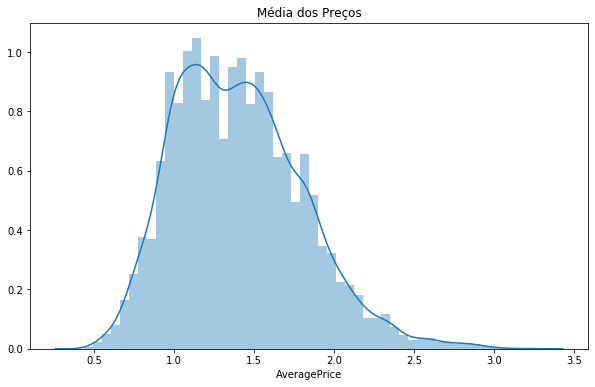

In [13]:
# definindo o tamanho do plot
plt.figure(figsize = (10, 6))

# plotando o gráfico
sns.distplot(df1['AveragePrice'])

# definindo o título
plt.title("Média dos Preços")

Podemos observar uma distribuição aproximadamente normal, com uma calda um pouco maior do lado direito, provavelmente nesses dados, há a presença de *outliers*. Além disso, tem dois picos e isso provavelmente pode indicar amostras de populações diferentes.

Vamos ver essa distribuição de outra forma, e dessa vez vamos separar os tipos, *conventional* e *organic*, e um ótima ferramenta para conferir se realmente há outliers é o `boxplot`.

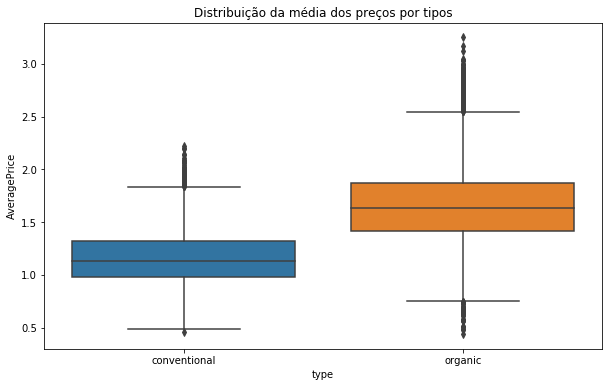

In [14]:
# definindo o tamanho do plot
plt.figure(figsize = (10, 6))

# plotando o gráfico
sns.boxplot(x = 'type', y = 'AveragePrice', data = df1)

# definindo o título
plt.title("Distribuição da média dos preços por tipos");

Dessa vez, está mais claro de enxergar! A distribuição dos dois tipos são um pouco diferentes (há técnicas estatísticas para saber se essa diferença pode influenciar ou não, mas não é foco deste trabalho). O **tipo "orgânico" tem mais outliers** do que o tipo convencional, assim como também observamos que há **dispersão maior** para este tipo.

Poderíamos remover os outliers e/ou também fazer uma normalização ou padronização, mas visando nosso objetivo e mencionado acima, uma das características do `Prophet` é trabalhar com outliers.

Também já dito anteriormente, uma das premissas para se trabalhar com série temporal é que deve manter a ordem correta dos acontecimentos dos eventos. Portanto vamos ordenar a coluna *Date*.

In [15]:
# ordenando a coluna data
df1 = df1.sort_values('Date')

Então vamos criar uma visualização desses dados, para enxergar o comportamento ao longo do tempo.

Text(0.5, 1.0, 'Média de preços ao longo do tempo')

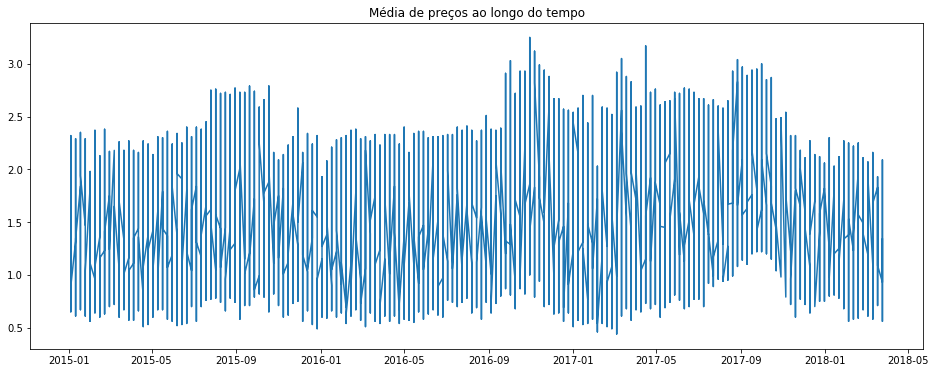

In [16]:
# definindo o tamanho do plot
plt.figure(figsize = (16, 6))

# plotando o gráfico
plt.plot(df1['Date'], df1['AveragePrice'])

# definindo o título
plt.title("Média de preços ao longo do tempo")

Não ficou muito bom para visualizar os dados diários, mas vamos melhorar isso mais a frente.

Vamos dar uma olhada a quantidade por ano com um `countplot` da biblioteca `Seaborn`.

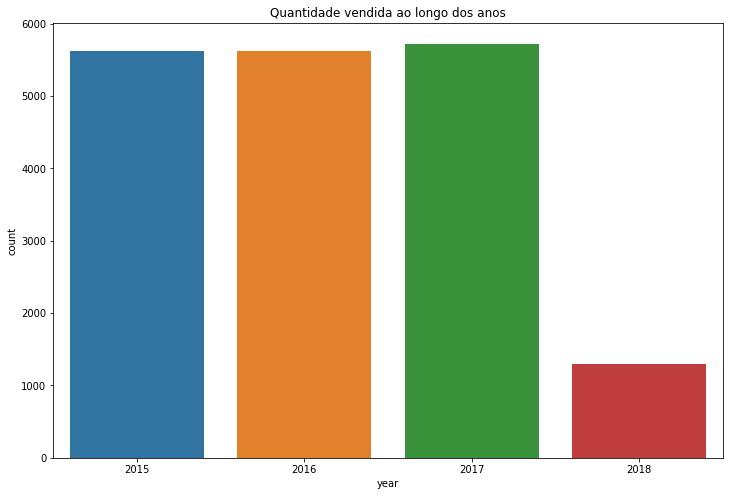

In [17]:
# definindo o tamanho do plot
plt.figure(figsize = (12, 8))

# plotando o gráfico
sns.countplot(x = 'year', data = df1)

# definindo o título
plt.title("Quantidade vendida ao longo dos anos");

Vamos fazer uma visualização da média dos preços por regiões por ano, para o tipo *conventional*, utilizando a função de `catplot` do `Seaborn`.

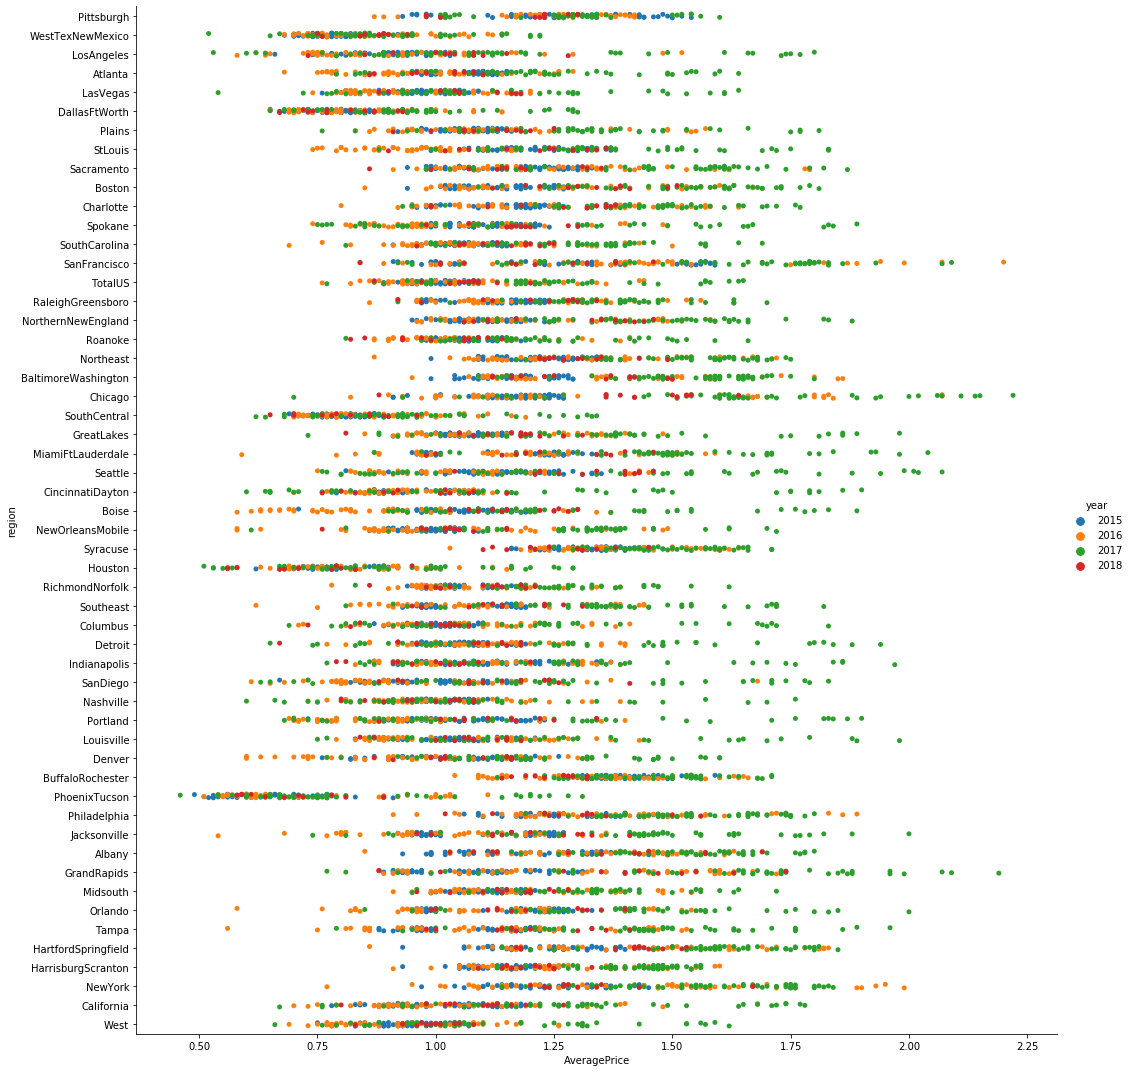

In [41]:
# plot preços vs regiões para avocados convencionais
conventional = sns.catplot('AveragePrice', 'region', data = df1[df1['type'] == 'conventional'], hue = 'year', height = 15)

Olhando para os pontos, parece que no ano de 2017 tivemos uma variação maior, em relação aos outros anos em praticamente todas as regiões.

Agora vamo dar uma olhada na média dos preços por regiões por ano, para o tipo *organic*.

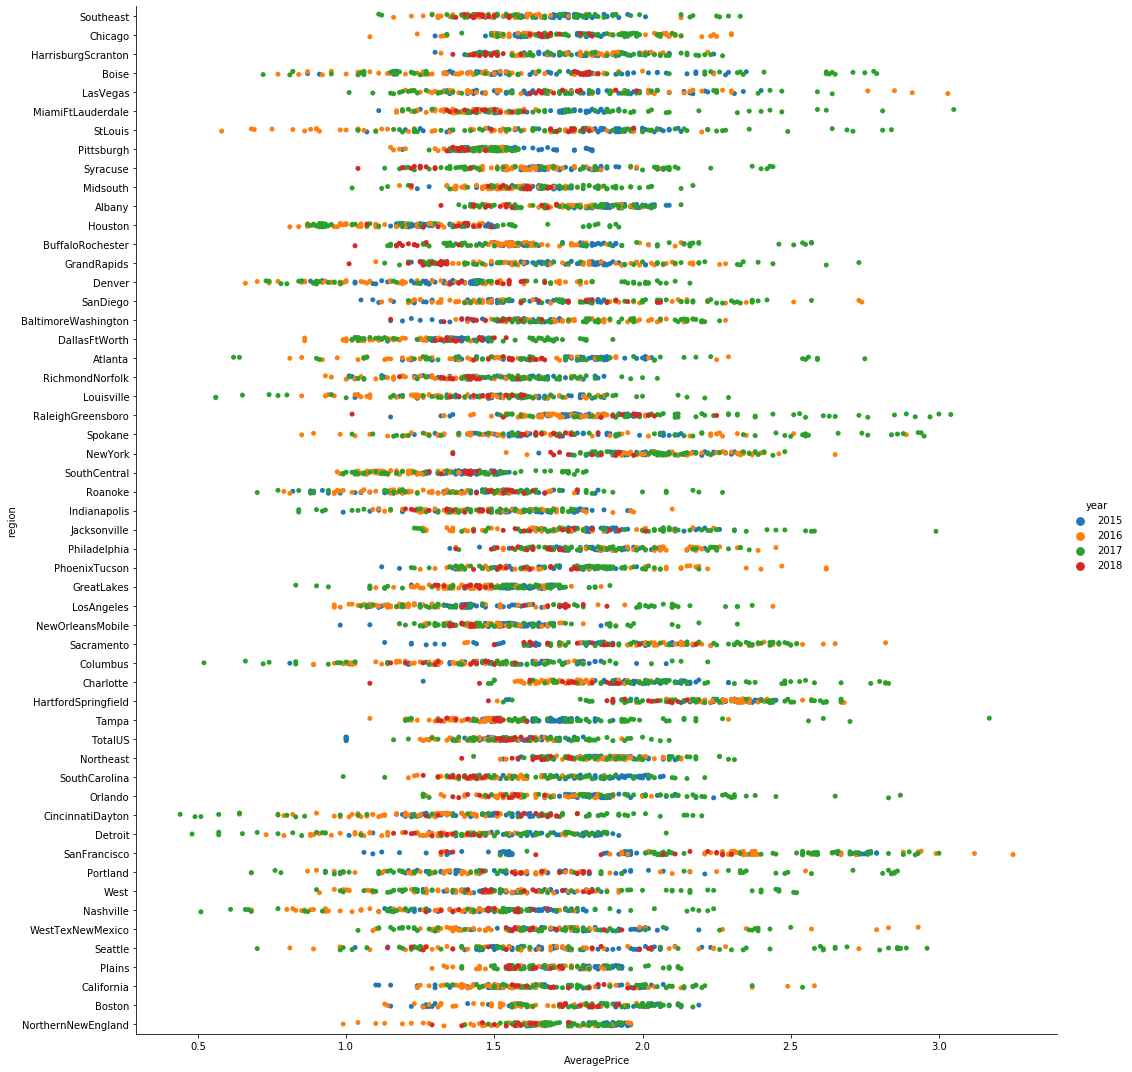

In [42]:
# plot preços vs regiões para avocados organicos
organic = sns.catplot('AveragePrice', 'region', data = df1[df1['type'] == 'organic'], hue = 'year', height = 15)

Em proporção menor, mas parece que os comportamentos são semelhantes dos dois tipos.<br>
Claro que estamos concluindo somente "batendo o olho", também poderiamos utilizar outras ferramentas para refinar a análise.

## Preparando os dados

Nesta etapa vamos preparar nossos dados para aplicar o *forecasting* com o `Facebook Prophet`.

Vamos iniciar, criando um outro dataframe somente com duas colunas, que serão as entradas para o *framework*, as colunas *Date* e *AveragePrice*.

In [20]:
# criando um data frame padrão
df_prophet = df1[['Date', 'AveragePrice']]

Vamos visualizar como ficou esse data frame.

In [21]:
# verificando as primeiras 5 linhas
df_prophet.head()

,Date,AveragePrice
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64


O `Prophet` espera receber um dataframe com duas colunas, como já fizemos acima, porém as colunas terão de ser renomeadas.<br>
As colunas devem estar renomeadas como **ds** (datestamp) para representar a coluna de **data** e **y** para representar a coluna que terão os dados e que servirão para as **previsões**. Vamos entender um pouco mais...

A coluna **ds** deverá estar no formato do `Pandas`, como **YYY-MM-DD** para data ou **YYYY-MM-DD HH:MM:SS** para timestamp.<br>
A coluna **y** deverá estar no formato **numérico** e representar as medições do que se deseja prever.

In [22]:
# renomeando as colunas
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'AveragePrice': 'y'})

Olhando o resultado.

In [23]:
# verificando as primeiras 5 linhas
df_prophet.head()

,ds,y
11569,2015-01-04,1.75
9593,2015-01-04,1.49
10009,2015-01-04,1.68
1819,2015-01-04,1.52
9333,2015-01-04,1.64


## O processo de previsões - Simples demonstração

O processo agora, segue o padrão do `sklearn`, criamos uma instancia do modelo, fazemos o `fit` (treinamento) e posteriormente o `predict` (previsão).

In [24]:
# instanciando o modelo
m = Prophet()

# realizando o treinamento
m.fit(df_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Modelo treinado! Vamos fazer a previsão, mas antes temos que definir o período que queremos que o modelo faça a previsão. Neste exemplo vamos querer que faça uma previsão de 365 dias, ou 1 ano, à frente.

O `Prophet` disponibiliza um dataframe adequado que se estenda para o futuro por um número especificado de dias (que escolhemos para prever) usando o método auxiliar `make_future_dataframe.

In [25]:
# método auxiliar para previsão
future = m.make_future_dataframe(periods = 365)

# previsão do modelo
forecast = m.predict(future)

Vamos olhar o resultado.<br>
A coluna **yhat** representa as previsões, o **yhat_lower** e **yhat_upper** são as componentes do intervalo de incertezas. Quanto mais distante o tempo à frente, mais incerto fica a previsão.

In [26]:
# verificando as primeiras 5 linhas
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-04,1.384809,0.906246,1.836127
1,2015-01-04,1.384809,0.885905,1.881537
2,2015-01-04,1.384809,0.936637,1.879869
3,2015-01-04,1.384809,0.928938,1.893896
4,2015-01-04,1.384809,0.913300,1.861932


Vamos visualizar essas previsões, com o método próprio do Prophet.

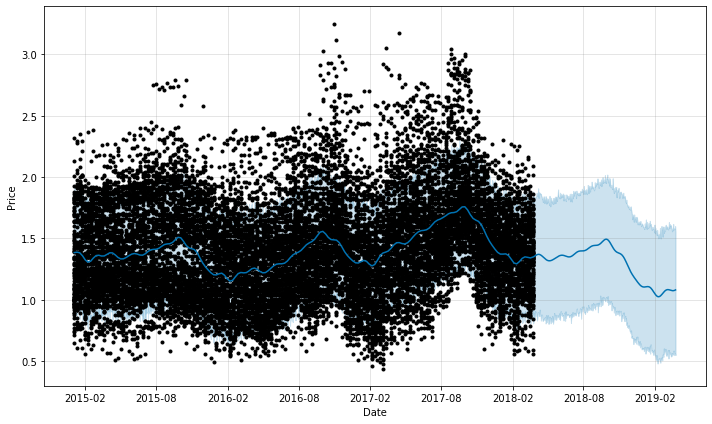

In [27]:
figure = m.plot(forecast, xlabel = 'Date', ylabel = 'Price')

Podemos visualizar também os seus componentes, **trend** (tendência) e **yearly seasonality** (sazonalidade anual).

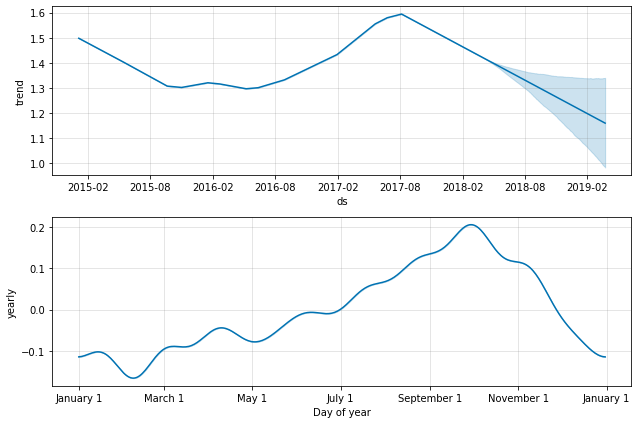

In [28]:
figure2 = m.plot_components(forecast)

## Treinando e testando um modelo

Agora que já vimos como o `Prophet` funciona, vamos fazer da forma correta, treinamento, teste e métricas.

Vamos começar dividindo nossos dados em dados de treino e teste. Criaremos um objeto para definir a "data fim" e a partir disso serão criados mais dois dataframes, todos os dados anterior à data de corte serão os dados de **treinamento** e o outro serão para os dados de **teste**.

Esta data foi definida arbitrariamente, não levando em consideração nenhum tipo de análise.

In [29]:
# definindo uma data de corte
data_fim = '2017-06-25'

# definindo os dados de treino, antes da data de corte
train = df_prophet.loc[df_prophet['ds'] <= data_fim]

# definindo os dados de teste posterior a data de corte
test = df_prophet.loc[df_prophet['ds'] > data_fim]

Para automatizar o processo, vamos criar um objeto com a quantidade de dias a serem previstos, pra isso basta tirar os dias repetidos dos dados de teste e fazer uma contagem.

Posteriormente isso servirá para inserir a quantidade de dias à frente para previsão como parâmetro.

In [30]:
# contando a quantidade de dias à frente para checar a acurácia da previsão
dias_a_prever = len(test.ds.unique())

# checando a quantidade de dias
dias_a_prever

39

Agora vamos dar uma olhada na separação dos dados, podemos juntar os dois e colocar em cores diferentes.

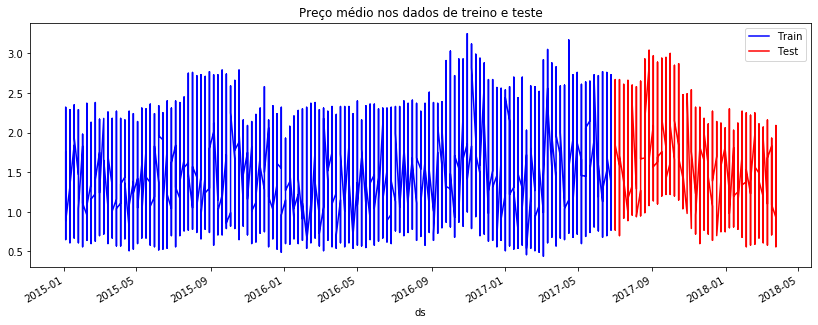

In [31]:
# definindo o tamanho do plot
f, ax = plt.subplots(figsize=(14,5))

# plotando os dados de treino
train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)

# plotando os dados de teste
test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)

# definindo o título
plt.title('Preço médio nos dados de treino e teste');

Precisamos definir uma métrica para checar.<br>
Vamos utilizar a métrica `MAPE` (Mean absolute percentage error). Essa métrica nos mostra o quanto do ajuste está errado percentualmente.

Vamos criar uma função para o MAPE.

In [32]:
# criando a função MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Agora vamos fazer uma previsão com os dados que separamos, seguindo o mesmo processo apresentado acima.<br>
Primeiro, com os dados de treino vamos prever um período à frente.

In [33]:
# instanciando o modelo
m = Prophet()

# realizando o treinamento
m.fit(train)

# método auxiliar para previsão
future = m.make_future_dataframe(periods=dias_a_prever)

# previsão do modelo
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
# olhando os resultados das previsões com os dados de treino
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
14071,2017-07-30,1.731081,1.202854,2.232854
14072,2017-07-31,1.733241,1.249492,2.248563
14073,2017-08-01,1.735339,1.248538,2.266794
14074,2017-08-02,1.737365,1.232849,2.231063
14075,2017-08-03,1.739306,1.211293,2.228066


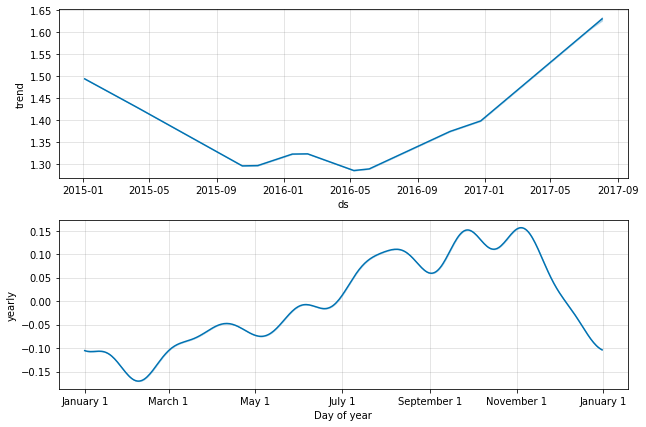

In [35]:
# Plotando os componentes
figure2 = m.plot_components(forecast)

Para melhorar a visualização, a partir do próximo plot, vou alterar algumas configurações.

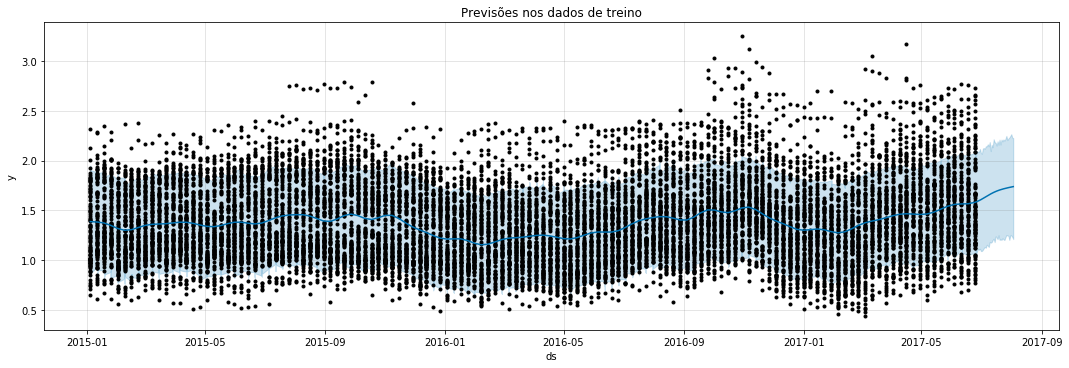

In [36]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)

# alterando a altura
fig.set_figheight(5)

# alterando a largura
fig.set_figwidth(15)

# plotando o gráfico
fig = m.plot(forecast, ax=ax)

# definindo o título
plt.title('Previsões nos dados de treino');

Agora vamos utilizar os dados de teste.

In [37]:
# fazendo previsões com os dados de teste
test_forecast = m.predict(test)

# olhando os resultados das previsões com os dados de teste
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
4205,2018-03-25,1.805966,1.315118,2.307096
4206,2018-03-25,1.805966,1.292138,2.303959
4207,2018-03-25,1.805966,1.313225,2.297404
4208,2018-03-25,1.805966,1.308621,2.317621
4209,2018-03-25,1.805966,1.277950,2.281528
4210,2018-03-25,1.805966,1.305231,2.308571
4211,2018-03-25,1.805966,1.331855,2.283407


Podemos checar os dados da previsão com o real, vamos comparar e depois checar o quanto o nosso modelo errou.

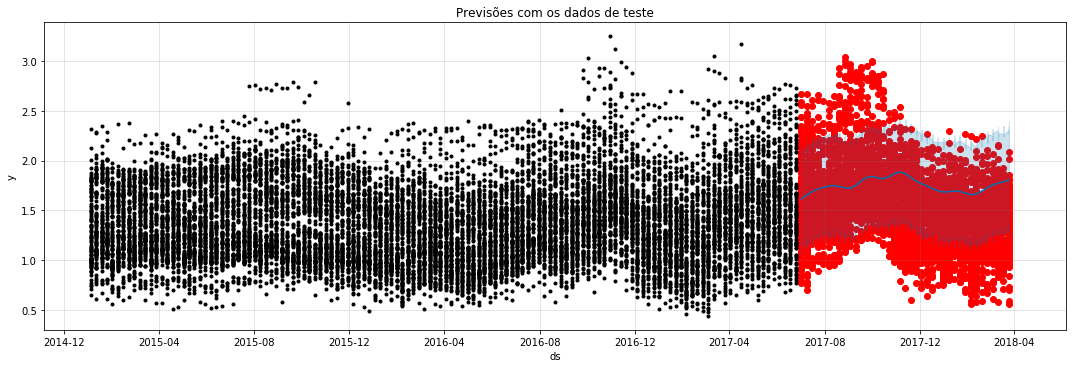

In [38]:
# configurando a área de plotagem
fig, ax = plt.subplots(1)

# alterando a altura
fig.set_figheight(5)

# alterando a largura
fig.set_figwidth(15)

# adicionando os dados de teste
ax.scatter(test.ds, test['y'], color='r')

# plotando o gráfico
fig = m.plot(test_forecast, ax=ax)

# definindo o título
plt.title('Previsões com os dados de teste');

Podemos ver que visualmente que o modelo não performou tão mal, porém temos que checar as métricas.<br>
Antes, vamos olhar somente a parte acrescentada, comparando os dados de teste com as previsões.

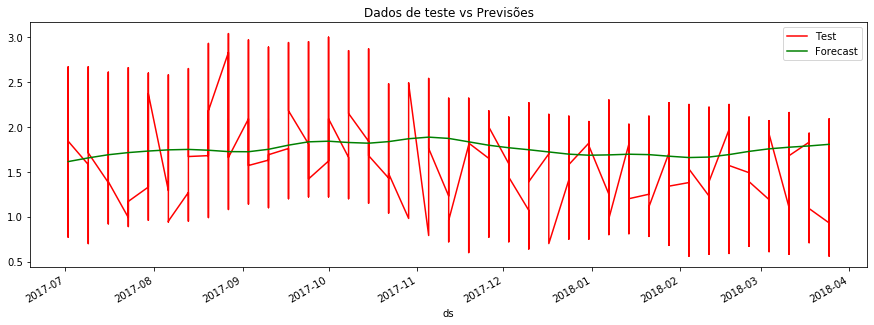

In [39]:
# configurando a área de plotagem
f, ax = plt.subplots(figsize=(14,5))

# alterando a altura
f.set_figheight(5)

# alterando a largura
f.set_figwidth(15)

# plotando o gráfico com dados de teste
test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)

# plotando o gráfico com os dados previstos
test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)

# definindo o título
plt.title('Dados de teste vs Previsões');

Agora vamos usar nossa função de MAPE para saber o percentual de erro do modelo.

In [40]:
mape = mean_absolute_percentage_error(test['y'],test_forecast['yhat'])
print("MAPE",round(mape,4))

MAPE 28.1674


## Conclusão

Nosso modelo errou 28%. Podemos melhorar? Claro que sim!<br>
Uma das coisas que temos que considerar quando lidamos com séries temporais são feriados que ocorrem ao longo do ano, além disso a empresa pode fazer uma campanha ou lançamento de um produto e isso influencia nas previsões, pois são oscilações que ocorrem ao longo dos períodos de avaliação.

Podemos adicionar os feriados, existe uma biblioteca que se chama *Holidays* que poderá nos auxliar nisso, mas isso não é tudo, pois junto com os feriados podemos adicionar outros parâmetros e também treinar um *grid search* para escolha dos melhores, obtendo assim uma melhora significativa, mas isso ficará para um próximo trabalho.

Fizemos uma análise exploratória básica e uma aplicação simples do modelo afim de demonstração e podemos dizer que o processo de *forecasting* do Prophet é fácil, intuitivo e poderoso. Com ele podemos resolver muitos problemas de séries temporais e em larga escala.

## Referências

Documentação oficial<br>
https://facebook.github.io/prophet/docs/quick_start.html#python-api

Projeto guiado do Coursera<br>
https://www.coursera.org/projects/prophet-timeseries-prediction

Portal SAS sobre Analytics<br>
https://www.sas.com/pt_br/insights/analytics/analytics.html

Wikipedia sobre Séries Temporais<br>
https://pt.wikipedia.org/wiki/S%C3%A9rie_temporal